# Testing out the functionality of Transfer learning using the Fashion MNIST data 

## Importing libraries

In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import seaborn as sns

## Loading dataset

In [2]:
(x_train_full, y_train_full), (x_test, y_test) = keras.datasets.fashion_mnist.load_data()

In [3]:
x_valid, x_train = x_train_full[:5000] / 255, x_train_full[5000:] / 255
y_valid, y_train = y_train_full[:5000], y_train_full[5000:]
x_test = x_test / 255

- We will be dividing the dataset into 2 groups A and B.
- Group A will be having all the images except that of sandals and shirt.
- Group B will be having the first 200 images of sandal and shirt.
- The validation and test data will also be split like this, without restricting the no. of images.

In [4]:
def split_dataset(x, y):
    y_5_or_6 = (y == 5) | (y == 6) 
    y_a = y[~y_5_or_6] 
    y_a[y_a > 6] -= 2 #Reducing the classes (7, 8, 9) to (5, 6, 7)
    y_b = (y[y_5_or_6] == 6).astype(np.float32) # getiing group b and converting the classes 6 to 1 and 5 to 0 as a binary classification task
    return ((x[~y_5_or_6], y_a), (x[y_5_or_6], y_b))

In [5]:
(x_train_a, y_train_a), (x_train_b, y_train_b) = split_dataset(x_train, y_train)
(x_valid_a, y_valid_a), (x_valid_b, y_valid_b) = split_dataset(x_valid, y_valid)
(x_test_a, y_test_a), (x_test_b, y_test_b) = split_dataset(x_test, y_test)

In [6]:
x_train_b = x_train_b[:200]
y_train_b = y_train_b[:200]

In [7]:
x_train_a.shape

(43986, 28, 28)

In [8]:
x_train_b.shape

(200, 28, 28)

In [9]:
y_train_a[:30]

array([4, 0, 5, 7, 7, 7, 4, 4, 3, 4, 0, 1, 6, 3, 4, 3, 2, 6, 5, 3, 4, 5,
       1, 3, 4, 2, 0, 6, 7, 1], dtype=uint8)

In [10]:
y_train_b[:30]

array([1., 1., 0., 0., 0., 0., 1., 1., 1., 0., 0., 1., 1., 0., 0., 0., 0.,
       0., 0., 1., 1., 0., 0., 1., 1., 0., 1., 1., 1., 1.], dtype=float32)

## Building the base model

In [11]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

In [12]:
model_a = keras.models.Sequential()
model_a.add(keras.layers.Flatten(input_shape = [28, 28]))
for n_units in (300, 100, 50, 50, 50):
    model_a.add(keras.layers.Dense(n_units, activation = 'selu'))
model_a.add(keras.layers.Dense(8, activation = 'softmax'))

In [13]:
model_a.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 784)               0         
_________________________________________________________________
dense (Dense)                (None, 300)               235500    
_________________________________________________________________
dense_1 (Dense)              (None, 100)               30100     
_________________________________________________________________
dense_2 (Dense)              (None, 50)                5050      
_________________________________________________________________
dense_3 (Dense)              (None, 50)                2550      
_________________________________________________________________
dense_4 (Dense)              (None, 50)                2550      
_________________________________________________________________
dense_5 (Dense)              (None, 8)                 4

## Compiling the base model

In [14]:
model_a.compile(loss = keras.losses.sparse_categorical_crossentropy, optimizer = keras.optimizers.SGD(lr = 1e-3), metrics = ['accuracy'])

## Training the base model

In [15]:
history = model_a.fit(x_train_a, y_train_a, epochs = 20, validation_data = (x_valid_a, y_valid_a))

Epoch 1/20
1375/1375 [==============================] - 3s 2ms/step - loss: 0.5926 - accuracy: 0.8103 - val_loss: 0.3892 - val_accuracy: 0.8675
Epoch 2/20
1375/1375 [==============================] - 2s 2ms/step - loss: 0.3523 - accuracy: 0.8788 - val_loss: 0.3290 - val_accuracy: 0.8819
Epoch 3/20
1375/1375 [==============================] - 2s 2ms/step - loss: 0.3170 - accuracy: 0.8896 - val_loss: 0.3013 - val_accuracy: 0.8989
Epoch 4/20
1375/1375 [==============================] - 2s 2ms/step - loss: 0.2973 - accuracy: 0.8975 - val_loss: 0.2894 - val_accuracy: 0.9023
Epoch 5/20
1375/1375 [==============================] - 3s 2ms/step - loss: 0.2835 - accuracy: 0.9021 - val_loss: 0.2774 - val_accuracy: 0.9068
Epoch 6/20
1375/1375 [==============================] - 2s 2ms/step - loss: 0.2729 - accuracy: 0.9061 - val_loss: 0.2731 - val_accuracy: 0.9066
Epoch 7/20
1375/1375 [==============================] - 2s 2ms/step - loss: 0.2641 - accuracy: 0.9091 - val_loss: 0.2718 - val_accuracy:

In [16]:
df_metrics_a = pd.DataFrame(history.history)

<AxesSubplot:>

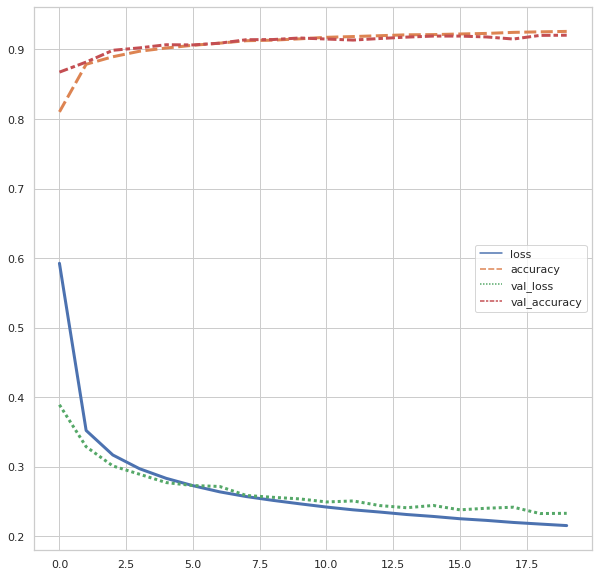

In [17]:
sns.set(style = 'whitegrid')
plt.figure(figsize = (10,10))
sns.lineplot(data = df_metrics_a, linewidth = 3)

## Evaluating the model

In [18]:
model_a.evaluate(x_test_a, y_test_a)

250/250 [==============================] - 0s 1ms/step - loss: 0.2528 - accuracy: 0.9105


[0.2527839243412018, 0.9104999899864197]

- We will be saving this model for reusing while building the second model

In [19]:
model_a.save('model_a.h5')

## Building the second model without transfer learning

In [20]:
model_b = keras.models.Sequential()
model_b.add(keras.layers.Flatten(input_shape = [28,28]))
for n_units in (300, 100, 50, 50, 50):
    model_b.add(keras.layers.Dense(n_units, activation = 'selu'))
model_b.add(keras.layers.Dense(1, activation = 'sigmoid'))

In [21]:
model_b.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 300)               235500    
_________________________________________________________________
dense_7 (Dense)              (None, 100)               30100     
_________________________________________________________________
dense_8 (Dense)              (None, 50)                5050      
_________________________________________________________________
dense_9 (Dense)              (None, 50)                2550      
_________________________________________________________________
dense_10 (Dense)             (None, 50)                2550      
_________________________________________________________________
dense_11 (Dense)             (None, 1)                

In [22]:
model_b.compile(loss = keras.losses.binary_crossentropy, optimizer = keras.optimizers.SGD(lr = 1e-3), metrics = ['accuracy'])

In [23]:
history = model_b.fit(x_train_b, y_train_b, epochs = 20, validation_data = (x_valid_b, y_valid_b))

Epoch 1/20
7/7 [==============================] - 0s 21ms/step - loss: 0.9573 - accuracy: 0.4650 - val_loss: 0.6314 - val_accuracy: 0.6004
Epoch 2/20
7/7 [==============================] - 0s 8ms/step - loss: 0.5692 - accuracy: 0.7450 - val_loss: 0.4784 - val_accuracy: 0.8529
Epoch 3/20
7/7 [==============================] - 0s 9ms/step - loss: 0.4503 - accuracy: 0.8650 - val_loss: 0.4102 - val_accuracy: 0.8945
Epoch 4/20
7/7 [==============================] - 0s 9ms/step - loss: 0.3879 - accuracy: 0.8950 - val_loss: 0.3647 - val_accuracy: 0.9178
Epoch 5/20
7/7 [==============================] - 0s 8ms/step - loss: 0.3435 - accuracy: 0.9250 - val_loss: 0.3300 - val_accuracy: 0.9320
Epoch 6/20
7/7 [==============================] - 0s 8ms/step - loss: 0.3081 - accuracy: 0.9300 - val_loss: 0.3019 - val_accuracy: 0.9402
Epoch 7/20
7/7 [==============================] - 0s 8ms/step - loss: 0.2800 - accuracy: 0.9350 - val_loss: 0.2804 - val_accuracy: 0.9422
Epoch 8/20
7/7 [=================

In [24]:
df_metrics_b = pd.DataFrame(history.history)

<AxesSubplot:>

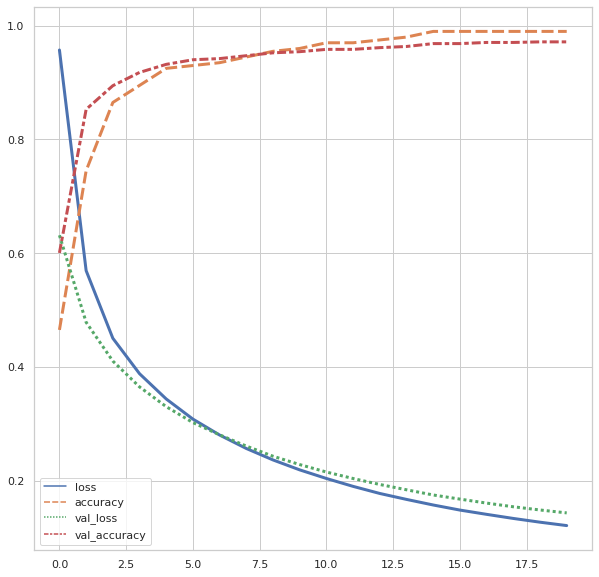

In [25]:
plt.figure(figsize = (10, 10))
sns.lineplot(data = df_metrics_b, linewidth = 3)

In [26]:
model_b.evaluate(x_test_b, y_test_b)

63/63 [==============================] - 0s 1ms/step - loss: 0.1408 - accuracy: 0.9705


[0.1408407837152481, 0.9704999923706055]

## Building model B on top of model A

In [27]:
model_a = keras.models.load_model('model_a.h5')

In [28]:
model_b_on_a = keras.models.Sequential(model_a.layers[:-1])
model_b_on_a.add(keras.layers.Dense(1, activation = 'sigmoid'))

- While we train model B which is built on top of model A, as they have some layers in common we will be changing the weights of model A also.
- To avoid that we need to clone model A.

In [29]:
model_b_on_a.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 784)               0         
_________________________________________________________________
dense (Dense)                (None, 300)               235500    
_________________________________________________________________
dense_1 (Dense)              (None, 100)               30100     
_________________________________________________________________
dense_2 (Dense)              (None, 50)                5050      
_________________________________________________________________
dense_3 (Dense)              (None, 50)                2550      
_________________________________________________________________
dense_4 (Dense)              (None, 50)                2550      
_________________________________________________________________
dense_12 (Dense)             (None, 1)                

In [30]:
model_a_clone = keras.models.clone_model(model_a)
model_a_clone.set_weights(model_a.get_weights())

- Since the new output layer in model B is randomly initialized, it may create huge errors in the ouputs.
- These errors may change the weights of the reused layers drastically during GD.
- So to avoid this we will be freezing the reused layers for the first few iterations till the weights of the new layer get optimized.

In [31]:
for layer in model_b_on_a.layers[:-1]:
    layer.trainable = False

In [32]:
model_b_on_a.compile(loss = keras.losses.binary_crossentropy, optimizer = keras.optimizers.SGD(lr = 1e-3), metrics = ['accuracy'])

In [33]:
model_b_on_a.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 784)               0         
_________________________________________________________________
dense (Dense)                (None, 300)               235500    
_________________________________________________________________
dense_1 (Dense)              (None, 100)               30100     
_________________________________________________________________
dense_2 (Dense)              (None, 50)                5050      
_________________________________________________________________
dense_3 (Dense)              (None, 50)                2550      
_________________________________________________________________
dense_4 (Dense)              (None, 50)                2550      
_________________________________________________________________
dense_12 (Dense)             (None, 1)                

In [34]:
history = model_b_on_a.fit(x_train_b, y_train_b, epochs = 4, validation_data = (x_valid_b, y_valid_b))

Epoch 1/4
7/7 [==============================] - 0s 19ms/step - loss: 0.5775 - accuracy: 0.6500 - val_loss: 0.5817 - val_accuracy: 0.6400
Epoch 2/4
7/7 [==============================] - 0s 8ms/step - loss: 0.5411 - accuracy: 0.6700 - val_loss: 0.5444 - val_accuracy: 0.6815
Epoch 3/4
7/7 [==============================] - 0s 8ms/step - loss: 0.5045 - accuracy: 0.7300 - val_loss: 0.5125 - val_accuracy: 0.7099
Epoch 4/4
7/7 [==============================] - 0s 8ms/step - loss: 0.4731 - accuracy: 0.7500 - val_loss: 0.4839 - val_accuracy: 0.7363


In [35]:
for layer in model_b_on_a.layers[:-1]:
    layer.trainable = True

- We have to set the learning rate at a much lower value in order to avoid changint the weights of the reused layers to a greater extent

In [36]:
model_b_on_a.compile(loss = keras.losses.binary_crossentropy, optimizer = keras.optimizers.SGD(lr = 1e-3), metrics = ['accuracy'])

In [37]:
history = model_b_on_a.fit(x_train_b, y_train_b, epochs = 16, validation_data = (x_valid_b, y_valid_b))

Epoch 1/16
7/7 [==============================] - 0s 19ms/step - loss: 0.3950 - accuracy: 0.8200 - val_loss: 0.3452 - val_accuracy: 0.8671
Epoch 2/16
7/7 [==============================] - 0s 8ms/step - loss: 0.2793 - accuracy: 0.9350 - val_loss: 0.2599 - val_accuracy: 0.9290
Epoch 3/16
7/7 [==============================] - 0s 8ms/step - loss: 0.2080 - accuracy: 0.9650 - val_loss: 0.2108 - val_accuracy: 0.9544
Epoch 4/16
7/7 [==============================] - 0s 8ms/step - loss: 0.1668 - accuracy: 0.9800 - val_loss: 0.1789 - val_accuracy: 0.9696
Epoch 5/16
7/7 [==============================] - 0s 8ms/step - loss: 0.1395 - accuracy: 0.9800 - val_loss: 0.1560 - val_accuracy: 0.9757
Epoch 6/16
7/7 [==============================] - 0s 8ms/step - loss: 0.1196 - accuracy: 0.9950 - val_loss: 0.1392 - val_accuracy: 0.9797
Epoch 7/16
7/7 [==============================] - 0s 8ms/step - loss: 0.1049 - accuracy: 0.9950 - val_loss: 0.1266 - val_accuracy: 0.9838
Epoch 8/16
7/7 [=================

In [38]:
model_b_on_a.evaluate(x_test_b, y_test_b)

63/63 [==============================] - 0s 1ms/step - loss: 0.0683 - accuracy: 0.9930


[0.06825263053178787, 0.9929999709129333]